<h1>CNN Cancer Detection Kaggle Mini-Project</h1>
<h2>1. Brief description of the problem and data</h2
This project involves the Histopathic Cancer Detection Kaggle Challenge, with a goal of training a model to be able to identify metastatic cancer in small image patches taken from larger digital pathology scans.

The dataset is very large, consisting of about 220,000 .tif images in the training set and about 57,500 .tif images in the test set. Each of the images in the training set corresponds to an ID and label in a dataframe. Labels are either 1 if the image indicates metastatic cancer or 0 if it does not.

The desired output for the project is a dataframe with a row for each of the ~57,500 test images, containing the image ID and a prediction of 0 or 1.

<h2>2. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data</h2>

In [37]:
#import some useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import time
from PIL import Image
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import random
import tkinter as tk
from tkinter import filedialog
from PIL import ImageTk
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from keras.layers import Cropping2D

#load the data
dir_train = '/Users/206509/CU/machine-learning/deep-learning/cancer/train'
dir_test = '/Users/206509/CU/machine-learning/deep-learning/cancer/test'
data_train = pd.read_csv('/Users/206509/CU/machine-learning/deep-learning/cancer/train_labels.csv')

#see basic info and check for nulls
print(data_train.info())
print(data_train.isnull().sum())
print(len(dir_train), len(dir_test))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None
id       0
label    0
dtype: int64
60 59


None of the training IDs or labels are null — great. How many are labeled 0 and how many are 1?

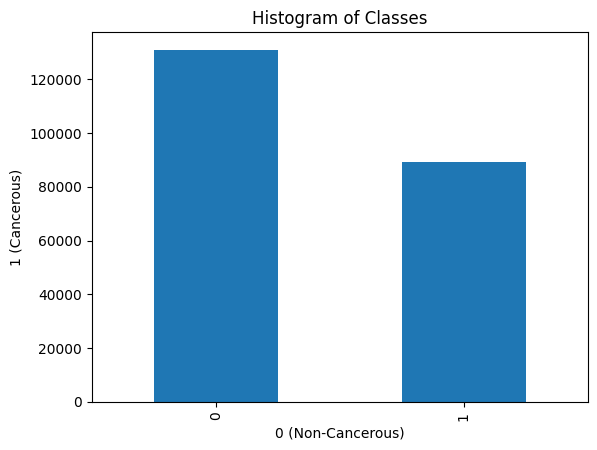

In [13]:
data_train['label'].value_counts().plot(kind='bar')
plt.xlabel('0 (Non-Cancerous)')
plt.ylabel('1 (Cancerous)')
plt.title(f'Histogram of Classes')
plt.show()

The classes are fairly balanced, also good. Next we'll have a look at a few of our training and test images to see what they look like.

Five sample training images:


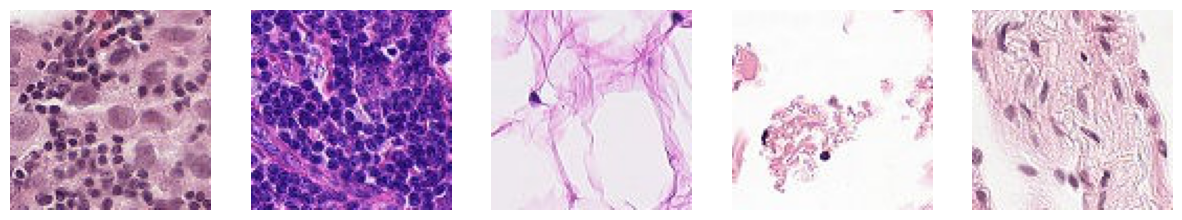

Five sample test images:


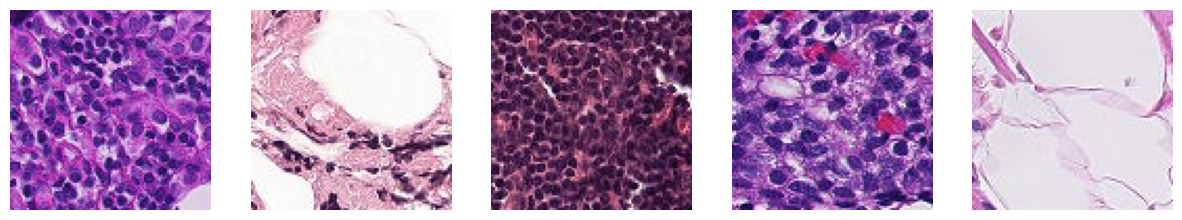

In [14]:
def print_random_images(directory, num_images=5):
    #get list of all files in the directory
    all_files = os.listdir(directory)
    
    image_files = [f for f in all_files if f.lower().endswith(('.tif'))]

    #select random images
    random_images = random.sample(image_files, min(num_images, len(image_files)))
    
    #print the selected images
    fig, axes = plt.subplots(1, len(random_images), figsize=(15, 5))
    for ax, image_file in zip(axes, random_images):
        image_path = os.path.join(directory, image_file)
        image = Image.open(image_path)
        ax.imshow(image)
        ax.axis('off')
    
    plt.show()

print(f"Five sample training images:")
print_random_images(dir_train)

print(f"Five sample test images:")
print_random_images(dir_test)

We can also check that there are 220,025 images in the folder and corresponding rows in the dataframe. 

This data is very clean and does not need further cleaning, but we can do some preprocessing: normalizing the image files for faster processing, adding a column to match filenames on and changing the label file type to categorical. Also, we'll have to crop the images so we're training and testing on only the center 32x32 pixel square, as indicated in the rules.

Based on this EDA, I think the best plan of analysis will be to use a convolutional neural network.

<h2>3. Model Architecture</h2>
As stated, we'll use a convolutional neural network; they are one of the most efficient and useful models to train on large sets of images for classification.

We can try a simple LeNet-style CNN, as outlined [here](https://www.kaggle.com/code/schmoyote/simple-cnn-architecture-for-image-classification). Then we can try a slightly more complicated architecture. In each case, we'll tune hyperparameters to see if we can get better results.

We'll normalize the image files when we create the ImageData.

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Epoch 1/10


/Users/206509/Library/Python/3.12/lib/python/site-packages/keras/src/layers/reshaping/cropping2d.py:57: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/206509/Library/Python/3.12/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 48s 9ms/step - accuracy: 0.7450 - loss: 0.5229 - val_accuracy: 0.7889 - val_loss: 0.4631
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 50s 9ms/step - accuracy: 0.7909 - loss: 0.4580 - val_accuracy: 0.8054 - val_loss: 0.4347
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 51s 9ms/step - accuracy: 0.8019 - loss: 0.4394 - val_accuracy: 0.8073 - val_loss: 0.4327
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 54s 10ms/step - accuracy: 0.8088 - loss: 0.4274 - val_accuracy: 0.8113 - val_loss: 0.4237
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 54s 10ms/step - accuracy: 0.8122 - loss: 0.4198 - val_accuracy: 0.8118 - val_loss: 0.4246
Epoch 6/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 54s 10ms/step - accuracy: 0.8146 - loss: 0.4142 - val_accuracy: 0.8062 - val_loss: 0.4323
Epoch 7/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 53s 10ms/step - accuracy: 0.8185 - loss: 0.4088 - val_accuracy: 0.8047 - val_loss: 0.4303
Epoch 8/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 55s 10ms/step - accuracy: 0.8231 - loss: 0.4001 

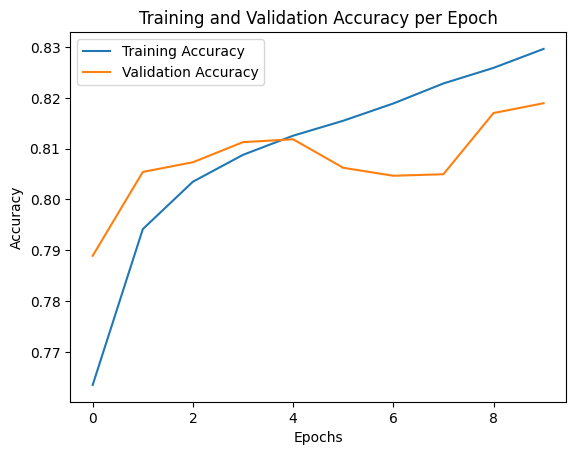

In [4]:
#create a new column in the data_train df to match filenames on and change labels to string
data_train['filename'] = data_train['id'].apply(lambda x: str(x) + '.tif')
data_train['label'] = data_train['label'].astype(str)

def cancer_cnn(image_directory, dataframe, label_column, batch_size=32, epochs=10, learning_rate=0.001):
    #use ImageDataGenerator to normalize images
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    
    #create training and validation generators
    train_generator = datagen.flow_from_dataframe(
        dataframe=data_train,
        directory=image_directory,
        x_col='filename',  # column with image file names
        y_col=label_column,  # column with labels
        target_size=(96, 96),  # original image size
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )
    
    validation_generator = datagen.flow_from_dataframe(
        dataframe=data_train,
        directory=image_directory,
        x_col='filename',  # column with image file names
        y_col=label_column,  # column with labels
        target_size=(96, 96),  # original image size
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )
    
    #define a neural network model with cropping
    model = Sequential([
        Cropping2D(cropping=((32, 32), (32, 32)), input_shape=(96, 96, 3)),  # Crop to center 32x32 pixels
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(len(dataframe[label_column].unique()), activation='softmax')
    ])
    
    #compile the model
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    #train the model
    history = model.fit(train_generator, epochs=epochs, validation_data=validation_generator)

    return model, history

def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

train_basic_model, basic_history = cancer_cnn(dir_train, data_train, 'label')

#after training, plot the accuracy over time
plot_accuracy(basic_history)

<h2>Hyperparameter tuning</h2>

I am pretty excited about this as a first try! Training and validation accuracy reached into the 83 percent range by the 10th epoch, and our training/validation accuracy plot doesn't seem to indicate overfitting. 

Let's adjust the function to be more customizable when it comes to hyperparameters. We can adjust a few of them — let's do a higher learning rate of 0.0025 (which will hopefully process faster) as well as a bigger batch size (which will provide more stable gradient estimates) and introduce dropout layers (to help avoid overfitting in case we overshoot the learning rate). We'll do slightly fewer epochs too. 

After that, let's try it with a lower learning rate (0.0001) and smaller batch size.

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Epoch 1/8


/Users/206509/Library/Python/3.12/lib/python/site-packages/keras/src/layers/reshaping/cropping2d.py:57: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/206509/Library/Python/3.12/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22003/22003 ━━━━━━━━━━━━━━━━━━━━ 124s 6ms/step - accuracy: 0.6948 - loss: 0.5803 - val_accuracy: 0.7543 - val_loss: 0.5298
Epoch 2/8
22003/22003 ━━━━━━━━━━━━━━━━━━━━ 123s 6ms/step - accuracy: 0.7516 - loss: 0.5249 - val_accuracy: 0.7570 - val_loss: 0.5215
Epoch 3/8
22003/22003 ━━━━━━━━━━━━━━━━━━━━ 122s 6ms/step - accuracy: 0.7540 - loss: 0.5203 - val_accuracy: 0.7640 - val_loss: 0.5128
Epoch 4/8
22003/22003 ━━━━━━━━━━━━━━━━━━━━ 117s 5ms/step - accuracy: 0.7553 - loss: 0.5199 - val_accuracy: 0.7492 - val_loss: 0.5379
Epoch 5/8
22003/22003 ━━━━━━━━━━━━━━━━━━━━ 125s 6ms/step - accuracy: 0.7576 - loss: 0.5153 - val_accuracy: 0.7614 - val_loss: 0.5242
Epoch 6/8
22003/22003 ━━━━━━━━━━━━━━━━━━━━ 129s 6ms/step - accuracy: 0.7579 - loss: 0.5180 - val_accuracy: 0.7408 - val_loss: 0.5494
Epoch 7/8
22003/22003 ━━━━━━━━━━━━━━━━━━━━ 127s 6ms/step - accuracy: 0.7572 - loss: 0.5174 - val_accuracy: 0.7539 - val_loss: 0.5529
Epoch 8/8
22003/22003 ━━━━━━━━━━━━━━━━━━━━ 121s 6ms/step - accuracy: 0.7505 - l

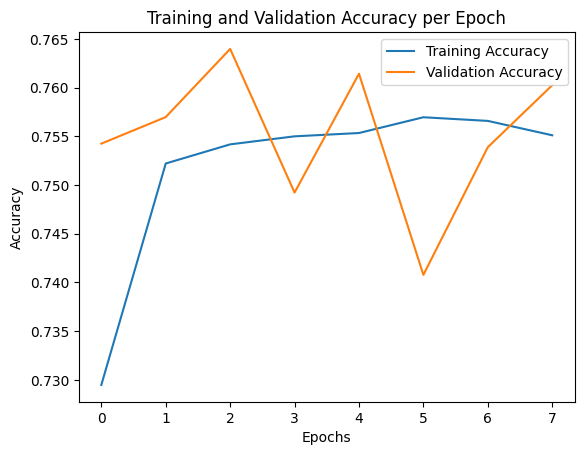

In [26]:
data_train['filename'] = data_train['id'].apply(lambda x: str(x) + '.tif')
data_train['label'] = data_train['label'].astype(str)

def tuned_cancer_cnn(image_directory, dataframe, label_column, batch_size=32, epochs=10, learning_rate=0.001):
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    train_generator = datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=image_directory,
        x_col='filename',  # column with image file names
        y_col=label_column,  # column with labels
        target_size=(96, 96),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=image_directory,
        x_col='filename',  # column with image file names
        y_col=label_column,  # column with labels
        target_size=(96, 96),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )

    model = Sequential([
        Cropping2D(cropping=((32, 32), (32, 32)), input_shape=(96, 96, 3)),  # Crop to center 32x32 pixels
        Conv2D(32, (3, 3), activation='relu'), 
        MaxPooling2D((2, 2)),
        Dropout(0.25),  
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25), 
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5), 
        Dense(len(dataframe[label_column].unique()), activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(train_generator, epochs=epochs, validation_data=validation_generator)

    return model, history

train_tuned_model, tuned_history = tuned_cancer_cnn(dir_train, data_train, 'label', batch_size=8, epochs=8, learning_rate=0.0025)

#plot the accuracy
plot_accuracy(tuned_history)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Epoch 1/10


/Users/206509/Library/Python/3.12/lib/python/site-packages/keras/src/layers/reshaping/cropping2d.py:57: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/206509/Library/Python/3.12/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11002/11002 ━━━━━━━━━━━━━━━━━━━━ 95s 9ms/step - accuracy: 0.7348 - loss: 0.5375 - val_accuracy: 0.7824 - val_loss: 0.4855
Epoch 2/10
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 94s 9ms/step - accuracy: 0.7783 - loss: 0.4792 - val_accuracy: 0.8030 - val_loss: 0.4596
Epoch 3/10
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 90s 8ms/step - accuracy: 0.7955 - loss: 0.4538 - val_accuracy: 0.7901 - val_loss: 0.4546
Epoch 4/10
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 99s 9ms/step - accuracy: 0.8067 - loss: 0.4352 - val_accuracy: 0.7826 - val_loss: 0.4641
Epoch 5/10
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 97s 9ms/step - accuracy: 0.8103 - loss: 0.4275 - val_accuracy: 0.8067 - val_loss: 0.4366
Epoch 6/10
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 96s 9ms/step - accuracy: 0.8154 - loss: 0.4189 - val_accuracy: 0.8149 - val_loss: 0.4187
Epoch 7/10
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 106s 10ms/step - accuracy: 0.8168 - loss: 0.4111 - val_accuracy: 0.8152 - val_loss: 0.4206
Epoch 8/10
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 98s 9ms/step - accuracy: 0.8210 - 

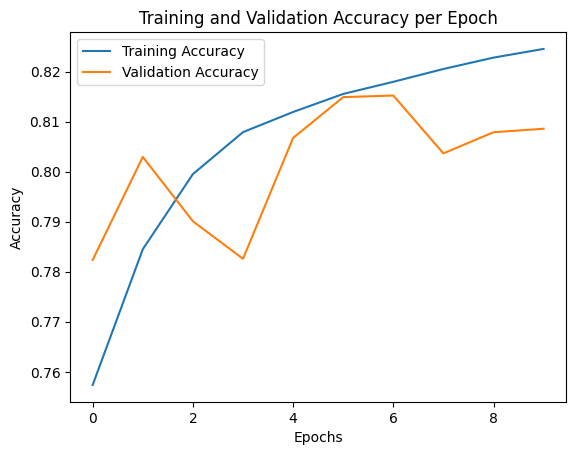

In [27]:
#another option — alternative model, with a smaller learning rate and larger batch size
train_alt_model, alt_history = tuned_cancer_cnn(dir_train, data_train, 'label', batch_size=16, epochs=10, learning_rate=0.0001)
plot_accuracy(alt_history)

So far this is only doing a little better than our original model, but it also looks like it might be still converging — which I would expect given that the training rate is rather small and we've only done 10 epochs. I have the luxury of time, so let's try it with twice as many.

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Epoch 1/20


/Users/206509/Library/Python/3.12/lib/python/site-packages/keras/src/layers/reshaping/cropping2d.py:57: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/206509/Library/Python/3.12/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11002/11002 ━━━━━━━━━━━━━━━━━━━━ 96s 9ms/step - accuracy: 0.7286 - loss: 0.5449 - val_accuracy: 0.7735 - val_loss: 0.4945
Epoch 2/20
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 94s 9ms/step - accuracy: 0.7742 - loss: 0.4864 - val_accuracy: 0.7920 - val_loss: 0.4635
Epoch 3/20
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 98s 9ms/step - accuracy: 0.7856 - loss: 0.4665 - val_accuracy: 0.8043 - val_loss: 0.4602
Epoch 4/20
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 96s 9ms/step - accuracy: 0.7968 - loss: 0.4508 - val_accuracy: 0.7941 - val_loss: 0.4571
Epoch 5/20
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 96s 9ms/step - accuracy: 0.8005 - loss: 0.4443 - val_accuracy: 0.8062 - val_loss: 0.4423
Epoch 6/20
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 97s 9ms/step - accuracy: 0.8077 - loss: 0.4327 - val_accuracy: 0.7921 - val_loss: 0.4788
Epoch 7/20
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 94s 9ms/step - accuracy: 0.8083 - loss: 0.4304 - val_accuracy: 0.7826 - val_loss: 0.4740
Epoch 8/20
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 97s 9ms/step - accuracy: 0.8115 - lo

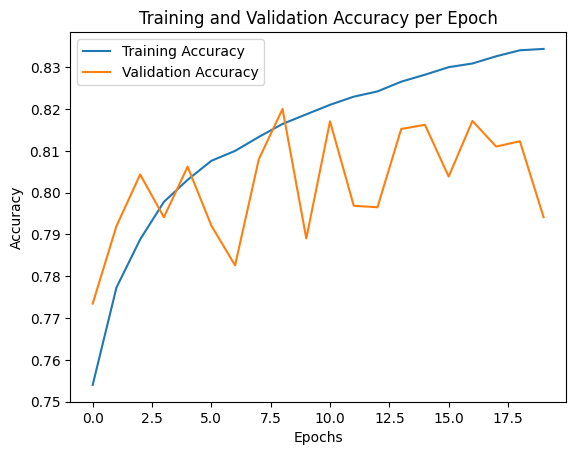

In [29]:
#more epochs, small learning rate model
more_epochs_model, more_epochs_history = tuned_cancer_cnn(dir_train, data_train, 'label', batch_size=16, epochs=20, learning_rate=0.0001)
plot_accuracy(more_epochs_history)

Huh, okay! Definitely looks like it's converging this time, but accuracy is not much higher after all.

<h2>Alternative architecture: batch normalization, more convolutions</h2>

Maybe we want to try a slightly different architecture altogether. We'll aim now for a deeper model that uses batch normalization at _each_ layer, not just the input layer, and that also includes more convolutions.

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Epoch 1/8


/Users/206509/Library/Python/3.12/lib/python/site-packages/keras/src/layers/reshaping/cropping2d.py:57: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/206509/Library/Python/3.12/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 108s 19ms/step - accuracy: 0.7567 - loss: 0.5498 - val_accuracy: 0.7100 - val_loss: 0.6375
Epoch 2/8
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 107s 19ms/step - accuracy: 0.7911 - loss: 0.4629 - val_accuracy: 0.8014 - val_loss: 0.4435
Epoch 3/8
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 110s 20ms/step - accuracy: 0.8061 - loss: 0.4365 - val_accuracy: 0.7809 - val_loss: 0.4759
Epoch 4/8
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 111s 20ms/step - accuracy: 0.8143 - loss: 0.4234 - val_accuracy: 0.7959 - val_loss: 0.4496
Epoch 5/8
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 110s 20ms/step - accuracy: 0.8186 - loss: 0.4128 - val_accuracy: 0.8188 - val_loss: 0.4188
Epoch 6/8
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 106s 19ms/step - accuracy: 0.8202 - loss: 0.4101 - val_accuracy: 0.7246 - val_loss: 0.8922
Epoch 7/8
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 109s 20ms/step - accuracy: 0.8222 - loss: 0.4059 - val_accuracy: 0.7558 - val_loss: 0.6472
Epoch 8/8
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 107s 19ms/step - accuracy: 0.8240 - loss: 0.4

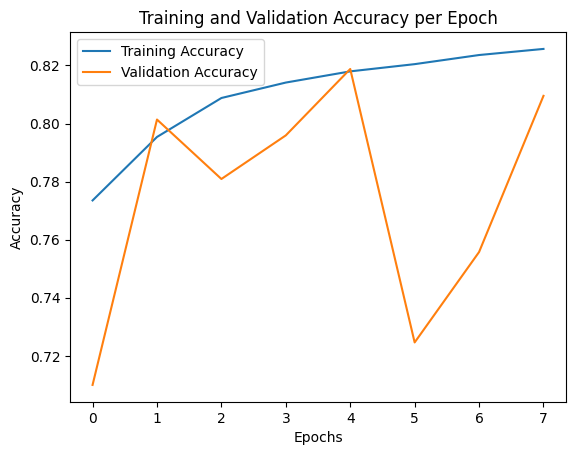

In [21]:
data_train['filename'] = data_train['id'].apply(lambda x: str(x) + '.tif')
data_train['label'] = data_train['label'].astype(str)

from keras.layers import BatchNormalization

def deeper_cnn(image_directory, dataframe, label_column, batch_size=32, epochs=10, learning_rate=0.001):
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    train_generator = datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=image_directory,
        x_col='filename',
        y_col=label_column,
        target_size=(96, 96),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=image_directory,
        x_col='filename',
        y_col=label_column,
        target_size=(96, 96),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )

    model = Sequential([
        Cropping2D(cropping=((32, 32), (32, 32)), input_shape=(96, 96, 3)), 
        Conv2D(32, (3, 3), activation='relu',),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        
        Dense(len(dataframe[label_column].unique()), activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(train_generator, epochs=epochs, validation_data=validation_generator)

    return model, history

deeper_model, deeper_history = deeper_cnn(dir_train, data_train, 'label', batch_size=32, epochs=8, learning_rate=0.0025)

plot_accuracy(deeper_history)

<h2>4. Results and Analysis</h2>

We've been printing histories and accuracy plots as we go along, so we already should have a good idea of the comparative value of the three variations on "cancer_cnn" (basic, tuned and alt) and the other architecture, "deeper_cnn" (with batch normalization and more convolutions), but let's sum it all up with a table to see it all in one place.

In [30]:
histories = {"Basic Model": basic_history, "Tuned Model": tuned_history, "Alternative Model": alt_history, 
             "More Epochs": more_epochs_history, "Deeper Model": deeper_history}

def summarize_history(histories):
    summary_data = []

    for model_name, history in histories.items():
        # Extract the final accuracy and loss for training and validation
        final_train_accuracy = history.history['accuracy'][-1]
        final_val_accuracy = history.history['val_accuracy'][-1]
        final_train_loss = history.history['loss'][-1]
        final_val_loss = history.history['val_loss'][-1]
        epochs = len(history.history['accuracy'])

        summary_data.append({
            "Model": model_name,
            "Epochs": epochs,
            "Final Training Accuracy": final_train_accuracy,
            "Final Validation Accuracy": final_val_accuracy,
            "Final Training Loss": final_train_loss,
            "Final Validation Loss": final_val_loss
        })

    #convert the list of data to a df
    summary_df = pd.DataFrame(summary_data)

    return summary_df

summary_results = summarize_history(histories)
print(summary_results)

               Model  Epochs  Final Training Accuracy  \
0        Basic Model      10                 0.829616   
1        Tuned Model       8                 0.755113   
2  Alternative Model      10                 0.824543   
3        More Epochs      20                 0.834377   
4       Deeper Model       8                 0.825707   

   Final Validation Accuracy  Final Training Loss  Final Validation Loss  
0                   0.818930             0.388524               0.411032  
1                   0.760255             0.517908               0.522740  
2                   0.808590             0.399495               0.421696  
3                   0.794114             0.379336               0.452240  
4                   0.809544             0.400048               0.423698  


In summary, the more-epochs model performed the best overall — it had both the highest accuracy (although the basic model and deeper model with more convolutions approached this) and the lowest loss (although again the basic model and deeper model were comparable). The tuned model likely had way too high a learning rate, as reflected by the big gulf between the training and validation accuracy. The alternative model performed okay but since the learning rate was really small, I think it may not have had time to converge. I think in both the tuned and alternative model, too, introducing dropouts was not helpful and may have contributed to information loss. More-epochs ran a bit slower (obviously) but not slow enough to rule it out.

I will use the more epochs model on the test data in order to enter the Kaggle competition.

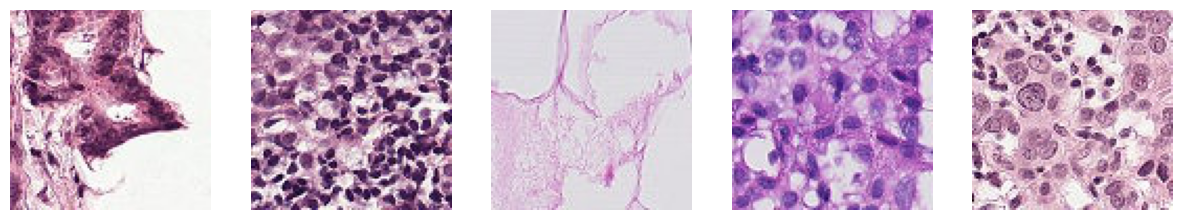

In [55]:
print_random_images(dir_test)

In [63]:
test_images = [f for f in os.listdir(dir_test) if f.endswith('.tif')]

test_df = pd.DataFrame({'filename': test_images, 'label': [None] * len(test_images)})

test_df['id'] = test_df['filename'].apply(lambda x: x.replace('.tif', ''))

print(f"Test dataframe head:\n {test_df.head()}")
def generate_test_predictions(test_directory=dir_test, model=more_epochs_model, batch_size=32):
    datagen = ImageDataGenerator(rescale=1./255)

    # Create test generator
    test_generator = datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=test_directory,
        x_col='filename',  # column with image file names
        y_col=None,  # No labels for test data
        target_size=(96, 96),
        batch_size=batch_size,
        class_mode=None,  # No labels for test data
        shuffle=False
    )

    print(f"Found {test_generator.samples} test images.")

    if test_generator.samples == 0:
        raise ValueError("No images found in the test directory. Please check the directory structure.")

    #load test images into a NumPy array
    test_images = []
    for _ in range(test_generator.samples // batch_size + 1):
        try:
            batch = next(test_generator)  # Get the next batch of images
            test_images.append(batch)  # Add batch to list
        except StopIteration:
            break  # Stop if there are no more batches

    #concatenate all batches into a single NumPy array
    test_images = np.concatenate(test_images, axis=0)

    #predict using the model
    predictions = model.predict(test_images)

    #convert predictions to class labels (0 or 1 based on highest probability)
    predicted_labels = np.argmax(predictions, axis=1)
    
    results_df = pd.DataFrame({'id': test_df['id'], 'label': predicted_labels})
    
    return results_df

#generate predictions and save to a CSV file
test_predictions = generate_test_predictions(dir_test, more_epochs_model)

test_predictions.to_csv('test_predictions.csv', index=False)

print("Test predictions saved to 'test_predictions.csv'")

Test dataframe head:
                                        filename label  \
0  fd0a060ef9c30c9a83f6b4bfb568db74b099154d.tif  None   
1  1f9ee06f06d329eb7902a2e03ab3835dd0484581.tif  None   
2  19709bec800f372d0b1d085da6933dd3ef108846.tif  None   
3  7a34fc34523063f13f0617f7518a0330f6187bd3.tif  None   
4  93be720ca2b95fe2126cf2e1ed752bd759e9b0ed.tif  None   

                                         id  
0  fd0a060ef9c30c9a83f6b4bfb568db74b099154d  
1  1f9ee06f06d329eb7902a2e03ab3835dd0484581  
2  19709bec800f372d0b1d085da6933dd3ef108846  
3  7a34fc34523063f13f0617f7518a0330f6187bd3  
4  93be720ca2b95fe2126cf2e1ed752bd759e9b0ed  
Found 57458 validated image filenames.
Found 57458 test images.
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
Test predictions saved to 'test_predictions.csv'


After loading into Kaggle, I ended up with a score of .8029.

<h2>5. Conclusion</h2>
I was able to train a model that turned in a good, not great performance on predicting presence of cancer cells in this dataset. With more time, I think I could get a better score by experimenting more with smaller learning rates, more epochs and different iterations of convolution.